In [6]:
import mne
#from mne_bids import (BIDSPath, read_raw_bids, print_dir_tree, make_report,
#                      find_matching_paths, get_entity_vals)
import numpy as np
import matplotlib.pyplot as plt
# import scipy as sp
# from scipy import signal
# import seaborn as sns
import pandas as pd
from pathlib import Path
import os
from time import time
from autoreject import AutoReject, Ransac, get_rejection_threshold

%matplotlib qt

In [3]:
# Initialize an empty dictionary for subject grouping
subject_groups = {}

# Add subjects to the dictionary based on their group
for i in range(1, 25):
    subject_groups[f"sub-{i:03d}"] = "htr" #Himalayan

for i in range(25, 56):
    subject_groups[f"sub-{i:03d}"] = "ctr" #Control

for i in range(56, 60):
    subject_groups[f"sub-{i:03d}"] = "tm" #Transcendental???

for i in range(60, 79):
    subject_groups[f"sub-{i:03d}"] = "vip" #Vipassana

for i in range(79, 99):
    subject_groups[f"sub-{i:03d}"] = "sny" #Shoonya Yoga


# Creating event id for each task and practice
event_id = {'htr/med1':1, 'htr/med2':2, 'htr/think1':3, 'htr/think2':4,
          'ctr/med1':5, 'ctr/med2':6, 'ctr/think1':7, 'ctr/think2':8,
          'tm/med1': 9, 'tm/med2' :10, 'tm/think1':11, 'tm/think2':12,
          'vip/med1':13, 'vip/med2':14, 'vip/think1':15, 'vip/think2':16,
          'sny/med1':17, 'sny/med2':18, 'sny/think1':19, 'sny/think2':20}




def load_task_data(bids_root, subject_id, tasks):
    """
    Load specific task EEG data for a subject from a BIDS-like dataset.
    
    Parameters:
    - bids_root: str, path to the root of the dataset.
    - subject_id: str, subject identifier (e.g., '088').
    - tasks: list of str, the task names to load (e.g., ['med2', 'think2']).
    
    Returns:
    - raw_dict: dict, containing MNE Raw objects for each task.
    """
    # Define the subject's EEG folder
    subject_path = os.path.join(bids_root, f"sub-{subject_id}", "eeg")
    
    if not os.path.exists(subject_path):
        raise FileNotFoundError(f"Subject folder not found: {subject_path}")
    
    raw_dict = {}  # Dictionary to hold Raw objects for each task
    
    for task in tasks:
        # Locate the BDF file for the specific task
        bdf_file = os.path.join(subject_path, f"sub-{subject_id}_task-{task}_eeg.bdf")
        if not os.path.exists(bdf_file):
            print(f"WARNING: BDF file not found for task '{task}'. Skipping...")
            continue
        
        # Load the BDF file
        raw = mne.io.read_raw_bdf(bdf_file, preload=True)
        print(f"Loaded BDF file for task '{task}': {bdf_file}")
        
        # Optionally, load metadata from JSON/TSV files
        # Metadata file paths
        json_file = os.path.join(subject_path, f"sub-{subject_id}_task-{task}_eeg.json")
        tsv_file = os.path.join(subject_path, f"sub-{subject_id}_task-{task}_channels.tsv")
        
        metadata = {}
        if os.path.exists(json_file):
            with open(json_file, 'r') as f:
                metadata['json'] = f.read()
            print(f"Loaded metadata JSON for task '{task}'")
        
        if os.path.exists(tsv_file):
            metadata['tsv'] = tsv_file  # Store TSV file path for later use if needed
            print(f"Loaded metadata TSV for task '{task}'")
        
        # Add the loaded data and metadata to the dictionary
        raw_dict[task] = {
            'raw': raw,
            'metadata': metadata
        }
    
    if not raw_dict:
        raise ValueError(f"No data was loaded for subject {subject_id} with tasks {tasks}.")
    
    return raw_dict



##### Initiating the preprocessing pipeline for the Braboszcz et al. (2017) dataset. ######

##### Loading data #####
Extracting EDF parameters from /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-078/eeg/sub-078_task-med2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 614399  =      0.000 ...   599.999 secs...
Loaded BDF file for task 'med2': /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-078/eeg/sub-078_task-med2_eeg.bdf
Loaded metadata JSON for task 'med2'
Loaded metadata TSV for task 'med2'
Extracting EDF parameters from /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-078/eeg/sub-078_task-think2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 622591  =      0.000 ...   607.999 secs...
Loaded BDF file for task 'think2': /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-078/eeg/sub-078_

/tmp/ipykernel_97582/3064138965.py:20: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2, GSR1, GSR2 has changed from V to NA.
  raw_med.set_channel_types({'EXG1': 'misc',
/tmp/ipykernel_97582/3064138965.py:36: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2, GSR1, GSR2 has changed from V to NA.
  raw_mw.set_channel_types({'EXG1': 'misc',
/tmp/ipykernel_97582/3064138965.py:75: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_med.interpolate_bads()
/tmp/ipykernel_97582/3064138965.py:76: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_mw.interpolate_bads()


New sampling frequency: 128.0 Hz

##### Averaging and filtering raw data #####
1 (FIFFV_MNE_CUSTOM_REF_ON)
1 (FIFFV_MNE_CUSTOM_REF_ON)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).


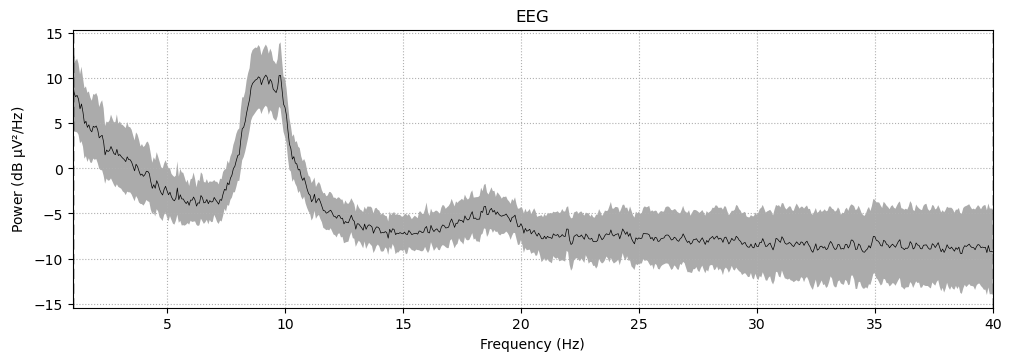

In [ ]:
# Print out intiation text with path to the dataset and events
print("\n##### Initiating the preprocessing pipeline for the Braboszcz et al. (2017) dataset. ######")

bids_root = "/home/sivert/Documents/Specialization_project/Datasets/ds003969/"
subject_id = "078"
tasks = ["med2", "think2"]
subject_group = subject_groups['sub-'+subject_id]


print('\n##### Loading data #####')
# Load data
subject_data = load_task_data(bids_root, subject_id, tasks)

# Access raw data for a specific task
raw_med = subject_data['med2']['raw']
raw_mw = subject_data['think2']['raw']

print('\n##### Channel types #####')
# Set channel types
raw_med.set_channel_types({'EXG1': 'misc',
                    'EXG2': 'misc',
                    'EXG3': 'misc',
                    'EXG4': 'misc',
                    'EXG5': 'misc',
                    'EXG6': 'misc',
                    'EXG7': 'misc',
                    'EXG8': 'misc',
                    'GSR1': 'misc',
                    'GSR2': 'misc',
                    'Erg1': 'misc',
                    'Erg2': 'misc',
                    'Resp': 'bio',
                    'Plet': 'bio',
                    'Temp': 'bio'
})
raw_mw.set_channel_types({'EXG1': 'misc',
                    'EXG2': 'misc',
                    'EXG3': 'misc',
                    'EXG4': 'misc',
                    'EXG5': 'misc',
                    'EXG6': 'misc',
                    'EXG7': 'misc',
                    'EXG8': 'misc',
                    'GSR1': 'misc',
                    'GSR2': 'misc',
                    'Erg1': 'misc',
                    'Erg2': 'misc',
                    'Resp': 'bio',
                    'Plet': 'bio',
                    'Temp': 'bio'
})

# Drop non-eeg channels
raw_med.pick('eeg')
raw_mw.pick('eeg')

# Verify the remaining channels
print(raw_med.info['ch_names'])

#Load the BioSemi 64-channel montage
montage = mne.channels.make_standard_montage('biosemi64')
raw_med.set_montage(montage)
raw_mw.set_montage(montage)

# Exclude bad channels
bad_channels_med = []
bad_channels_mw = []
raw_med.info['bads'] = bad_channels_med
raw_mw.info['bads'] = bad_channels_mw

print('Bad channels in meditation block:', raw_med.info['bads']) 
print('Bad channels in thinking block:', raw_mw.info['bads'])  

# Interpolate bad channels
raw_med.interpolate_bads()
raw_mw.interpolate_bads()

# Verify that the bad channels have been interpolated
print(raw_med.info['bads'])  # Should be an empty list
print(raw_mw.info['bads'])  # Should be an empty list

# Plot the data
#raw_med.plot()
#raw_mw.plot()

print("\n##### Downsampling #####")

# Downsample the data to 128 Hz
raw_med.resample(sfreq=128, npad="auto", verbose=False)
raw_mw.resample(sfreq=128, npad="auto", verbose=False)

# Print the new sampling frequency
print(f"New sampling frequency: {raw_med.info['sfreq']} Hz")

print("\n##### Averaging and filtering raw data #####")

preprocessed_data_med = raw_med.copy()
preprocessed_data_mw = raw_mw.copy()
# Apply an average reference to the data
preprocessed_data_med.set_eeg_reference(ref_channels='average', verbose=False)
preprocessed_data_mw.set_eeg_reference(ref_channels='average', verbose=False)

# Filter out low frequencies and high frequencies
preprocessed_data_med.filter(l_freq=1, h_freq=40, verbose=False)
preprocessed_data_mw.filter(l_freq=1, h_freq=40, verbose=False)

# average reference
preprocessed_data_med.set_eeg_reference(ref_channels='average', verbose=False)
preprocessed_data_mw.set_eeg_reference(ref_channels='average', verbose=False)

# Verify the new reference
print(preprocessed_data_med.info['custom_ref_applied'])  # Should be 1 if referencing was applied
print(preprocessed_data_mw.info['custom_ref_applied'])  # Should be 1 if referencing was applied


# Plot the data
preprocessed_data_med.plot()
preprocessed_data_mw.plot()

preprocessed_data_med.plot_psd(fmin=1, fmax=40, average=True)
preprocessed_data_mw.plot_psd(fmin=1, fmax=40, average=True)



In [10]:


print("\n##### ICA analysis meditation data #####")
def run_ica(method, data, fit_params=None):
    ica = mne.preprocessing.ICA(
        n_components=20,
        method=method,
        fit_params=fit_params,
        max_iter="auto",
        random_state=97,
    )
    t0 = time()
    ica.fit(data, reject={'eeg': 200e-6})
    fit_time = time() - t0
    title = f"ICA decomposition using {method} (took {fit_time:.1f}s)"
    ica.plot_components(title=title)
    ica.plot_sources(data)
    return ica


ica = run_ica("infomax", preprocessed_data_med)


##### ICA analysis meditation data #####
Fitting ICA to data using 64 channels (please be patient, this may take a while)
    Rejecting  epoch based on EEG : ['F5']
Artifact detected in [512, 768]
    Rejecting  epoch based on EEG : ['F5']
Artifact detected in [5120, 5376]
    Rejecting  epoch based on EEG : ['FCz']
Artifact detected in [9728, 9984]
    Rejecting  epoch based on EEG : ['FCz']
Artifact detected in [9984, 10240]
    Rejecting  epoch based on EEG : ['FCz']
Artifact detected in [11776, 12032]
    Rejecting  epoch based on EEG : ['F5', 'F7', 'F8']
Artifact detected in [52992, 53248]
Selecting by number: 20 components
Computing Infomax ICA
Fitting ICA took 6.1s.
Creating RawArray with float64 data, n_channels=20, n_times=76928
    Range : 0 ... 76927 =      0.000 ...   600.992 secs
Ready.


In [89]:
ica.exclude = [4] # select components to exclude
ICA_cleaned_data_med = preprocessed_data_med.copy()
ica.apply(ICA_cleaned_data_med)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)


    Zeroing out 1 ICA component
    Projecting back using 64 PCA components


<RawEDF | sub-072_task-med2_eeg.bdf, 64 x 77824 (608.0 s), ~38.1 MB, data loaded>

In [90]:
run_ica('infomax', preprocessed_data_mw)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
    Rejecting  epoch based on EEG : ['T8']
Artifact detected in [10496, 10752]
    Rejecting  epoch based on EEG : ['F7', 'F8', 'FT8', 'FC4', 'C4', 'C6', 'T8', 'TP8', 'CP6']
Artifact detected in [20224, 20480]
    Rejecting  epoch based on EEG : ['Iz']
Artifact detected in [22016, 22272]
    Rejecting  epoch based on EEG : ['AF7', 'F5', 'F7']
Artifact detected in [22528, 22784]
    Rejecting  epoch based on EEG : ['FT8', 'FC4', 'C4', 'C6', 'T8', 'TP8', 'CP6']
Artifact detected in [22784, 23040]
    Rejecting  epoch based on EEG : ['F8']
Artifact detected in [24064, 24320]
    Rejecting  epoch based on EEG : ['Iz', 'F8', 'TP8', 'P8']
Artifact detected in [24320, 24576]
    Rejecting  epoch based on EEG : ['Iz', 'P8']
Artifact detected in [24576, 24832]
    Rejecting  epoch based on EEG : ['TP8', 'P8']
Artifact detected in [24832, 25088]
    Rejecting  epoch based on EEG : ['Iz', 'TP8']
Artifact detected in 

Method,infomax
Fit parameters,extended=Falsemax_iter=500
Fit,500 iterations on raw data (71680 samples)
ICA components,20
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


In [91]:
ica.exclude = [] # select components to exclude
ICA_cleaned_data_mw = preprocessed_data_mw.copy()
ica.apply(ICA_cleaned_data_mw)

Applying ICA to Raw instance


    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


<RawEDF | sub-072_task-think2_eeg.bdf, 64 x 77696 (607.0 s), ~38.0 MB, data loaded>

**Creating epochs of the processed data MEDITATION**

In [92]:
# Define the length of each epoch (in seconds)
epoch_length = 5  # 5 seconds

# Create custom events: start at 0, 5, 10, ... seconds
n_samples = ICA_cleaned_data_med.n_times
sfreq = ICA_cleaned_data_med.info['sfreq']
epochs_samples = np.arange(0, n_samples, epoch_length * sfreq, dtype=int)

# Create event array with [sample, 0, event_id] for each epoch
event_code = event_id[f"{subject_group}/med2"]
events = np.column_stack([epochs_samples, np.zeros(len(epochs_samples), dtype=int), event_code * np.ones(len(epochs_samples), dtype=int)])

# Create event id for meditation task
event_id_med = {f"{subject_group}/med2": event_code}

# Define the epochs object using the custom events
epochs_med = mne.Epochs(ICA_cleaned_data_med, events, event_id=event_id_med, tmin=0, tmax=epoch_length, baseline=None, detrend=1, preload=True)

print("\n##### Autorejecting bad epochs #####")

epochs_original_med = epochs_med.copy()

ar = AutoReject() ################################                                    REMEMBER TO CITE
epochs_med, reject_log = ar.fit_transform(epochs_med, return_log=True)
get_rejection_threshold(epochs_med)  # Get the rejection threshold dictionary

rsc = Ransac()
epochs_med = rsc.fit_transform(epochs_med)

#  Plot the epoch average before and after autorejection and RANSAC
evoked_before = epochs_original_med.average()
evoked_after = epochs_med.average()

# Dropping bad epochs after autorejection
reject = dict(eeg=200-6)
epochs_med.drop_bad(reject=reject)
epochs_med.plot_drop_log()

# Create a figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 6))  # 1 row, 2 columns

# Plot the averages
evoked_before.plot(axes=axes[0], show=False, spatial_colors=True, time_unit='s')
axes[0].set_title("Average Before Auto-Rejection")

evoked_after.plot(axes=axes[1], show=False, spatial_colors=True, time_unit='s')
axes[1].set_title("Average After Auto-Rejection")

# Adjust layout
plt.tight_layout()

# save the plot
output_dir = "./plots/autoreject"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir,f"sub-{subject_id}_meditation_task_epoch_averages_before_after.png"))
plt.show()

Not setting metadata
122 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 122 events and 641 original time points ...
1 bad epochs dropped

##### Autorejecting bad epochs #####
Running autoreject on ch_type=eeg


100%|██████████| Creating augmented epochs : 64/64 [00:01<00:00,   53.10it/s]
100%|██████████| Computing thresholds ... : 64/64 [00:32<00:00,    1.97it/s]
































































100%|██████████| Repairing epochs : 121/121 [00:01<00:00,   70.65it/s]


























































































































100%|██████████| Repairing epochs : 121/121 [00:02<00:00,   43.54it/s]






















100%|██████████| Fold : 10/10 [00:03<00:00,    2.84it/s]


























































































































100%|██████████| Repairing epochs : 121/121 [00:02<00:00,   42.51it/s]






















100%|██████████| Fold : 10/10 [00:03<00:00,    2.85it/s]


























































































































100%|██████████| Repairing epochs : 121/121 





Estimated consensus=0.70 and n_interpolate=32




























































































































100%|██████████| Repairing epochs : 121/121 [00:02<00:00,   43.39it/s]


Dropped 1 epoch: 69
Estimating rejection dictionary for eeg


100%|██████████| interpolating channels : 50/50 [00:00<00:00,  802.81it/s]
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
100%|██████████| Iterating epochs : 120/120 [00:03<00:00,   31.13it/s]
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    3.9s


[Done]
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors
0 bad epochs dropped


/tmp/ipykernel_39351/68277501.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


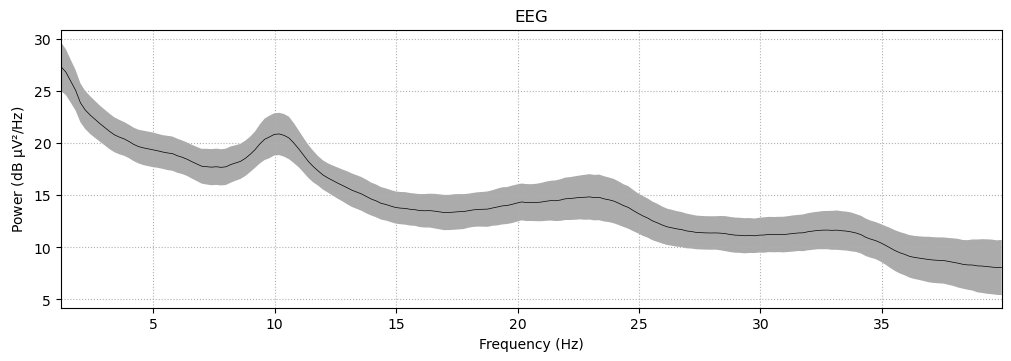

In [93]:
epochs_med.plot_psd(fmin=1, fmax=40, average=True, spatial_colors=True)
#epochs_med.plot()

**Creating epochs of the processed data THINKING**

In [94]:
# Define the length of each epoch (in seconds)
epoch_length = 5  # 5 seconds

# Create custom events: start at 0, 5, 10, ... seconds
n_samples = ICA_cleaned_data_mw.n_times
sfreq = ICA_cleaned_data_mw.info['sfreq']
epochs_samples = np.arange(0, n_samples, epoch_length * sfreq, dtype=int)

# Create event array with [sample, 0, event_id] for each epoch
event_code = event_id[f"{subject_group}/think2"]
events = np.column_stack([epochs_samples, np.zeros(len(epochs_samples), dtype=int), event_code * np.ones(len(epochs_samples), dtype=int)])

# create event_id for think task
event_id_think = {f"{subject_group}/think2": event_code}

# Define the epochs object using the custom events
epochs_mw = mne.Epochs(ICA_cleaned_data_mw, events, event_id=event_id_think, tmin=0, tmax=epoch_length, baseline=None, detrend=1, preload=True)

print("\n##### Autorejecting bad epochs #####")

epochs_original_mw = epochs_mw.copy()

epochs_mw, reject_log = ar.fit_transform(epochs_mw, return_log=True)
get_rejection_threshold(epochs_mw)  # Get the rejection threshold dictionary
epochs_mw = rsc.fit_transform(epochs_mw)

#  Plot the epoch average before and after autorejection and RANSAC
evoked_before = epochs_original_mw.average()
evoked_after = epochs_mw.average()

# Dropping bad epochs after autorejection
reject = dict(eeg=200-6)
epochs_mw.drop_bad(reject=reject)
epochs_mw.plot_drop_log()

# Create a figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 6))  # 1 row, 2 columns

# Plot the averages
evoked_before.plot(axes=axes[0], show=False, spatial_colors=True, time_unit='s')
axes[0].set_title("Average Before Auto-Rejection")

evoked_after.plot(axes=axes[1], show=False, spatial_colors=True, time_unit='s')
axes[1].set_title("Average After Auto-Rejection")

# Adjust layout
plt.tight_layout()

# save the plot
output_dir = "./plots/autoreject"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir,f"sub-{subject_id}_think_task_epoch_averages_before_after.png"))
plt.show()

Not setting metadata
122 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 122 events and 641 original time points ...
1 bad epochs dropped

##### Autorejecting bad epochs #####
Running autoreject on ch_type=eeg


100%|██████████| Creating augmented epochs : 64/64 [00:01<00:00,   52.64it/s]
100%|██████████| Computing thresholds ... : 64/64 [00:31<00:00,    2.00it/s]















































































100%|██████████| Repairing epochs : 121/121 [00:01<00:00,   65.82it/s]


























































































































100%|██████████| Repairing epochs : 121/121 [00:02<00:00,   41.02it/s]






















100%|██████████| Fold : 10/10 [00:03<00:00,    2.71it/s]
























































































































100%|██████████| Repairing epochs : 121/121 [00:02<00:00,   49.95it/s]






















100%|██████████| Fold : 10/10 [00:03<00:00,    2.74it/s]


























































































































100%|██████████| Repairing epoc





Estimated consensus=0.80 and n_interpolate=32




























































































































100%|██████████| Repairing epochs : 121/121 [00:02<00:00,   40.83it/s]

Dropped 9 epochs: 35, 38, 39, 49, 63, 65, 87, 98, 99


Estimating rejection dictionary for eeg


100%|██████████| interpolating channels : 50/50 [00:00<00:00,  777.68it/s]
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
100%|██████████| Iterating epochs : 112/112 [00:03<00:00,   30.62it/s]
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    3.7s


[Done]
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors
0 bad epochs dropped


/tmp/ipykernel_39351/1774122231.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


**Saving the epochs**

In [95]:
def save_epochs(epochs_med, epochs_mw, subject_id):
    # Merge the two epochs objects
    epochs_combined = mne.concatenate_epochs([epochs_med, epochs_mw])
    
    # Create the output directory if it doesn't exist
    output_dir = os.path.join("epochs", "internal_task")
    os.makedirs(output_dir, exist_ok=True)
    
    # Define the filename
    combined_filename = os.path.join(output_dir, f"sub-{subject_id}_epo.fif")
    
    # Save the combined epochs object
    epochs_combined.save(combined_filename, overwrite=True)
    
    print(f"Saved combined epochs to {combined_filename}")


save_epochs(epochs_med, epochs_mw, subject_id)

Not setting metadata
232 matching events found


No baseline correction applied
Saved combined epochs to epochs/internal_task/sub-072_epo.fif


**Auto cleaning data**

In [8]:
bids_root = "/home/sivert/Documents/Specialization_project/Datasets/ds003969/"
subjects = ["060", "061", "062", "063", "064", "065", "066", "067", "068", "069", "070", "071"]
tasks = ["med2", "think2"]
subject_group = subject_groups['sub-'+subject_id]

def save_epochs(epochs_med, epochs_mw, subject_id):
    # Merge the two epochs objects
    epochs_combined = mne.concatenate_epochs([epochs_med, epochs_mw])
    
    # Create the output directory if it doesn't exist
    output_dir = os.path.join("epochs", "internal_task")
    os.makedirs(output_dir, exist_ok=True)
    
    # Define the filename
    combined_filename = os.path.join(output_dir, f"sub-{subject_id}_epo.fif")
    
    # Save the combined epochs object
    epochs_combined.save(combined_filename, overwrite=True)
    
    print(f"Saved combined epochs to {combined_filename}")

for subject_id in subjects:
    print(f"\n##### Preprocessing subject {subject_id} #####")

    subject_data = load_task_data(bids_root, subject_id, tasks)

    # Access raw data for a specific task
    raw_med = subject_data['med2']['raw']
    raw_mw = subject_data['think2']['raw']

    print('\n##### Channel types #####')
    # Set channel types
    raw_med.set_channel_types({'EXG1': 'misc',
                        'EXG2': 'misc',
                        'EXG3': 'misc',
                        'EXG4': 'misc',
                        'EXG5': 'misc',
                        'EXG6': 'misc',
                        'EXG7': 'misc',
                        'EXG8': 'misc',
                        'GSR1': 'misc',
                        'GSR2': 'misc',
                        'Erg1': 'misc',
                        'Erg2': 'misc',
                        'Resp': 'bio',
                        'Plet': 'bio',
                        'Temp': 'bio'
    })
    raw_mw.set_channel_types({'EXG1': 'misc',
                        'EXG2': 'misc',
                        'EXG3': 'misc',
                        'EXG4': 'misc',
                        'EXG5': 'misc',
                        'EXG6': 'misc',
                        'EXG7': 'misc',
                        'EXG8': 'misc',
                        'GSR1': 'misc',
                        'GSR2': 'misc',
                        'Erg1': 'misc',
                        'Erg2': 'misc',
                        'Resp': 'bio',
                        'Plet': 'bio',
                        'Temp': 'bio'
    })

    # Drop non-eeg channels
    raw_med.pick('eeg')
    raw_mw.pick('eeg')

    # Verify the remaining channels
    print(raw_med.info['ch_names'])

    #Load the BioSemi 64-channel montage
    montage = mne.channels.make_standard_montage('biosemi64')
    raw_med.set_montage(montage)
    raw_mw.set_montage(montage)

    # Exclude bad channels
    bad_channels_med = []
    bad_channels_mw = []
    if subject_id == "069":
        bad_channels = ["PO4", "PO8", "O2"]
        raw_med.info['bads'] = bad_channels
        raw_mw.info['bads'] = bad_channels

    print('Bad channels in meditation block:', raw_med.info['bads']) 
    print('Bad channels in thinking block:', raw_mw.info['bads'])  

    # Interpolate bad channels
    raw_med.interpolate_bads()
    raw_mw.interpolate_bads()

    # Verify that the bad channels have been interpolated
    print(raw_med.info['bads'])  # Should be an empty list
    print(raw_mw.info['bads'])  # Should be an empty list

    # Plot the data
    #raw_med.plot()
    #raw_mw.plot()

    print("\n##### Downsampling #####")

    # Downsample the data to 128 Hz
    raw_med.resample(sfreq=128, npad="auto", verbose=False)
    raw_mw.resample(sfreq=128, npad="auto", verbose=False)

    # Print the new sampling frequency
    print(f"New sampling frequency: {raw_med.info['sfreq']} Hz")

    print("\n##### Averaging and filtering raw data #####")

    preprocessed_data_med = raw_med.copy()
    preprocessed_data_mw = raw_mw.copy()
    # Apply an average reference to the data
    preprocessed_data_med.set_eeg_reference(ref_channels='average', verbose=False)
    preprocessed_data_mw.set_eeg_reference(ref_channels='average', verbose=False)

    # Filter out low frequencies and high frequencies
    preprocessed_data_med.filter(l_freq=1, h_freq=40, verbose=False)
    preprocessed_data_mw.filter(l_freq=1, h_freq=40, verbose=False)

    # average reference
    preprocessed_data_med.set_eeg_reference(ref_channels='average', verbose=False)
    preprocessed_data_mw.set_eeg_reference(ref_channels='average', verbose=False)

    # Verify the new reference
    print(preprocessed_data_med.info['custom_ref_applied'])  # Should be 1 if referencing was applied
    print(preprocessed_data_mw.info['custom_ref_applied'])  # Should be 1 if referencing was applied


    preprocessed_data_med.plot_psd(fmin=1, fmax=40, average=True)
    preprocessed_data_mw.plot_psd(fmin=1, fmax=40, average=True)
    ICA_cleaned_data_med = preprocessed_data_med.copy()
    ICA_cleaned_data_mw = preprocessed_data_mw.copy()

    # Define the length of each epoch (in seconds)
    epoch_length = 5  # 5 seconds

    # Create custom events: start at 0, 5, 10, ... seconds
    n_samples = ICA_cleaned_data_med.n_times
    sfreq = ICA_cleaned_data_med.info['sfreq']
    epochs_samples = np.arange(0, n_samples, epoch_length * sfreq, dtype=int)

    # Create event array with [sample, 0, event_id] for each epoch
    event_code = event_id[f"{subject_group}/med2"]
    events = np.column_stack([epochs_samples, np.zeros(len(epochs_samples), dtype=int), event_code * np.ones(len(epochs_samples), dtype=int)])

    # Create event id for meditation task
    event_id_med = {f"{subject_group}/med2": event_code}

    # Define the epochs object using the custom events
    epochs_med = mne.Epochs(ICA_cleaned_data_med, events, event_id=event_id_med, tmin=0, tmax=epoch_length, baseline=None, detrend=1, preload=True)

    print("\n##### Autorejecting bad epochs #####")

    epochs_original_med = epochs_med.copy()

    ar = AutoReject() ################################                                    REMEMBER TO CITE
    epochs_med, reject_log = ar.fit_transform(epochs_med, return_log=True)
    get_rejection_threshold(epochs_med)  # Get the rejection threshold dictionary

    rsc = Ransac()
    epochs_med = rsc.fit_transform(epochs_med)

    #  Plot the epoch average before and after autorejection and RANSAC
    evoked_before = epochs_original_med.average()
    evoked_after = epochs_med.average()

    # Dropping bad epochs after autorejection
    reject = dict(eeg=200-6)
    epochs_med.drop_bad(reject=reject)
    epochs_med.plot_drop_log()

    # Create a figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 6))  # 1 row, 2 columns

    # Plot the averages
    evoked_before.plot(axes=axes[0], show=False, spatial_colors=True, time_unit='s')
    axes[0].set_title("Average Before Auto-Rejection")

    evoked_after.plot(axes=axes[1], show=False, spatial_colors=True, time_unit='s')
    axes[1].set_title("Average After Auto-Rejection")

    # Adjust layout
    plt.tight_layout()

    # save the plot
    output_dir = "./plots/autoreject"
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir,f"sub-{subject_id}_meditation_task_epoch_averages_before_after.png"))
    plt.show()

    epochs_med.plot_psd(fmin=1, fmax=40, average=True, spatial_colors=False)

    # Create custom events: start at 0, 5, 10, ... seconds
    n_samples = ICA_cleaned_data_mw.n_times
    sfreq = ICA_cleaned_data_mw.info['sfreq']
    epochs_samples = np.arange(0, n_samples, epoch_length * sfreq, dtype=int)

    # Create event array with [sample, 0, event_id] for each epoch
    event_code = event_id[f"{subject_group}/think2"]
    events = np.column_stack([epochs_samples, np.zeros(len(epochs_samples), dtype=int), event_code * np.ones(len(epochs_samples), dtype=int)])

    # create event_id for think task
    event_id_think = {f"{subject_group}/think2": event_code}

    # Define the epochs object using the custom events
    epochs_mw = mne.Epochs(ICA_cleaned_data_mw, events, event_id=event_id_think, tmin=0, tmax=epoch_length, baseline=None, detrend=1, preload=True)

    print("\n##### Autorejecting bad epochs #####")

    epochs_original_mw = epochs_mw.copy()

    epochs_mw, reject_log = ar.fit_transform(epochs_mw, return_log=True)
    get_rejection_threshold(epochs_mw)  # Get the rejection threshold dictionary
    epochs_mw = rsc.fit_transform(epochs_mw)

    #  Plot the epoch average before and after autorejection and RANSAC
    evoked_before = epochs_original_mw.average()
    evoked_after = epochs_mw.average()

    # Dropping bad epochs after autorejection
    reject = dict(eeg=200-6)
    epochs_mw.drop_bad(reject=reject)
    epochs_mw.plot_drop_log()

    # Create a figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 6))  # 1 row, 2 columns

    # Plot the averages
    evoked_before.plot(axes=axes[0], show=False, spatial_colors=True, time_unit='s')
    axes[0].set_title("Average Before Auto-Rejection")

    evoked_after.plot(axes=axes[1], show=False, spatial_colors=True, time_unit='s')
    axes[1].set_title("Average After Auto-Rejection")

    # Adjust layout
    plt.tight_layout()

    # save the plot
    output_dir = "./plots/autoreject"
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir,f"sub-{subject_id}_think_task_epoch_averages_before_after.png"))
    plt.show()





    save_epochs(epochs_med, epochs_mw, subject_id)


##### Preprocessing subject 060 #####
Extracting EDF parameters from /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-060/eeg/sub-060_task-med2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 617471  =      0.000 ...   602.999 secs...
Loaded BDF file for task 'med2': /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-060/eeg/sub-060_task-med2_eeg.bdf
Loaded metadata JSON for task 'med2'
Loaded metadata TSV for task 'med2'
Extracting EDF parameters from /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-060/eeg/sub-060_task-think2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 629759  =      0.000 ...   614.999 secs...
Loaded BDF file for task 'think2': /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-060/eeg/sub-060_task-think2_eeg.bdf
Loaded metadata JSON for task 'think2'
Loaded metadata TSV f

/tmp/ipykernel_97582/156053950.py:33: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2, GSR1, GSR2 has changed from V to NA.
  raw_med.set_channel_types({'EXG1': 'misc',
/tmp/ipykernel_97582/156053950.py:49: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2, GSR1, GSR2 has changed from V to NA.
  raw_mw.set_channel_types({'EXG1': 'misc',
/tmp/ipykernel_97582/156053950.py:90: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_med.interpolate_bads()
/tmp/ipykernel_97582/156053950.py:91: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_mw.interpolate_bads()


New sampling frequency: 128.0 Hz

##### Averaging and filtering raw data #####
1 (FIFFV_MNE_CUSTOM_REF_ON)
1 (FIFFV_MNE_CUSTOM_REF_ON)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 121 events and 641 original time points ...
1 bad epochs dropped

##### Autorejecting bad epochs #####
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Estimating rejection dictionary for eeg


  0%|          | interpolating channels : 0/50 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s


  0%|          | Iterating epochs : 0/120 [00:00<?,       ?it/s]

[Done]
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 61 sensor positions
Interpolating 3 sensors
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.4s
/tmp/ipykernel_97582/156053950.py:185: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 641 original time points ...
1 bad epochs dropped

##### Autorejecting bad epochs #####
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/122 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/122 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/122 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/122 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.90 and n_interpolate=32


  0%|          | Repairing epochs : 0/122 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Estimating rejection dictionary for eeg


  0%|          | interpolating channels : 0/50 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s


  0%|          | Iterating epochs : 0/122 [00:00<?,       ?it/s]

[Done]
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.5s
/tmp/ipykernel_97582/156053950.py:238: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Not setting metadata
242 matching events found
No baseline correction applied
Saved combined epochs to epochs/internal_task/sub-060_epo.fif

##### Preprocessing subject 061 #####
Extracting EDF parameters from /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-061/eeg/sub-061_task-med2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 619519  =      0.000 ...   604.999 secs...
Loaded BDF file for task 'med2': /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-061/eeg/sub-061_task-med2_eeg.bdf
Loaded metadata JSON for task 'med2'
Loaded metadata TSV for task 'med2'
Extracting EDF parameters from /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-061/eeg/sub-061_task-think2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 620543  =      0.000 ...   605.999 secs...
Loaded BDF file for task 'think2': /home/sivert/Documents/S

/tmp/ipykernel_97582/156053950.py:33: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2, GSR1, GSR2 has changed from V to NA.
  raw_med.set_channel_types({'EXG1': 'misc',
/tmp/ipykernel_97582/156053950.py:49: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2, GSR1, GSR2 has changed from V to NA.
  raw_mw.set_channel_types({'EXG1': 'misc',
/tmp/ipykernel_97582/156053950.py:90: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_med.interpolate_bads()
/tmp/ipykernel_97582/156053950.py:91: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_mw.interpolate_bads()


New sampling frequency: 128.0 Hz

##### Averaging and filtering raw data #####
1 (FIFFV_MNE_CUSTOM_REF_ON)
1 (FIFFV_MNE_CUSTOM_REF_ON)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 121 events and 641 original time points ...
1 bad epochs dropped

##### Autorejecting bad epochs #####
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.90 and n_interpolate=32


  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Estimating rejection dictionary for eeg


  0%|          | interpolating channels : 0/50 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s


  0%|          | Iterating epochs : 0/120 [00:00<?,       ?it/s]

[Done]
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.5s
/tmp/ipykernel_97582/156053950.py:185: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Not setting metadata
122 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 122 events and 641 original time points ...
1 bad epochs dropped

##### Autorejecting bad epochs #####
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.80 and n_interpolate=32


  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

Dropped 1 epoch: 68
Estimating rejection dictionary for eeg


  0%|          | interpolating channels : 0/50 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s


  0%|          | Iterating epochs : 0/120 [00:00<?,       ?it/s]

[Done]
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.4s
/tmp/ipykernel_97582/156053950.py:238: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Not setting metadata
240 matching events found
No baseline correction applied
Saved combined epochs to epochs/internal_task/sub-061_epo.fif

##### Preprocessing subject 062 #####
Extracting EDF parameters from /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-062/eeg/sub-062_task-med2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 615423  =      0.000 ...   600.999 secs...
Loaded BDF file for task 'med2': /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-062/eeg/sub-062_task-med2_eeg.bdf
Loaded metadata JSON for task 'med2'
Loaded metadata TSV for task 'med2'
Extracting EDF parameters from /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-062/eeg/sub-062_task-think2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 619519  =      0.000 ...   604.999 secs...
Loaded BDF file for task 'think2': /home/sivert/Documents/S

/tmp/ipykernel_97582/156053950.py:33: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2, GSR1, GSR2 has changed from V to NA.
  raw_med.set_channel_types({'EXG1': 'misc',
/tmp/ipykernel_97582/156053950.py:49: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2, GSR1, GSR2 has changed from V to NA.
  raw_mw.set_channel_types({'EXG1': 'misc',
/tmp/ipykernel_97582/156053950.py:90: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_med.interpolate_bads()
/tmp/ipykernel_97582/156053950.py:91: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_mw.interpolate_bads()


New sampling frequency: 128.0 Hz

##### Averaging and filtering raw data #####
1 (FIFFV_MNE_CUSTOM_REF_ON)
1 (FIFFV_MNE_CUSTOM_REF_ON)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 121 events and 641 original time points ...
1 bad epochs dropped

##### Autorejecting bad epochs #####
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Estimating rejection dictionary for eeg


  0%|          | interpolating channels : 0/50 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s


  0%|          | Iterating epochs : 0/120 [00:00<?,       ?it/s]

[Done]
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 61 sensor positions
Interpolating 3 sensors
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.4s
/tmp/ipykernel_97582/156053950.py:185: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 121 events and 641 original time points ...
1 bad epochs dropped

##### Autorejecting bad epochs #####
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Estimating rejection dictionary for eeg


  0%|          | interpolating channels : 0/50 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s


  0%|          | Iterating epochs : 0/120 [00:00<?,       ?it/s]

[Done]
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 61 sensor positions
Interpolating 3 sensors
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.5s
/tmp/ipykernel_97582/156053950.py:228: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(2, 1, figsize=(12, 6))  # 1 row, 2 columns
/tmp/ipykernel_97582/156053950.py:238: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Not setting metadata
240 matching events found
No baseline correction applied
Saved combined epochs to epochs/internal_task/sub-062_epo.fif

##### Preprocessing subject 063 #####
Extracting EDF parameters from /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-063/eeg/sub-063_task-med2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 619519  =      0.000 ...   604.999 secs...
Loaded BDF file for task 'med2': /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-063/eeg/sub-063_task-med2_eeg.bdf
Loaded metadata JSON for task 'med2'
Loaded metadata TSV for task 'med2'
Extracting EDF parameters from /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-063/eeg/sub-063_task-think2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 622591  =      0.000 ...   607.999 secs...
Loaded BDF file for task 'think2': /home/sivert/Documents/S

/tmp/ipykernel_97582/156053950.py:33: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2, GSR1, GSR2 has changed from V to NA.
  raw_med.set_channel_types({'EXG1': 'misc',
/tmp/ipykernel_97582/156053950.py:49: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2, GSR1, GSR2 has changed from V to NA.
  raw_mw.set_channel_types({'EXG1': 'misc',
/tmp/ipykernel_97582/156053950.py:90: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_med.interpolate_bads()
/tmp/ipykernel_97582/156053950.py:91: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_mw.interpolate_bads()


New sampling frequency: 128.0 Hz

##### Averaging and filtering raw data #####
1 (FIFFV_MNE_CUSTOM_REF_ON)
1 (FIFFV_MNE_CUSTOM_REF_ON)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 121 events and 641 original time points ...
1 bad epochs dropped

##### Autorejecting bad epochs #####
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=32


  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

Dropped 1 epoch: 40
Estimating rejection dictionary for eeg


  0%|          | interpolating channels : 0/50 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s


  0%|          | Iterating epochs : 0/119 [00:00<?,       ?it/s]

[Done]
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 57 sensor positions
Interpolating 7 sensors
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.4s
/tmp/ipykernel_97582/156053950.py:185: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Not setting metadata
122 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 122 events and 641 original time points ...
1 bad epochs dropped

##### Autorejecting bad epochs #####
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=32


  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Estimating rejection dictionary for eeg


  0%|          | interpolating channels : 0/50 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s


  0%|          | Iterating epochs : 0/121 [00:00<?,       ?it/s]

[Done]
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 56 sensor positions
Interpolating 8 sensors
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.5s
/tmp/ipykernel_97582/156053950.py:238: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Not setting metadata
240 matching events found
No baseline correction applied
Saved combined epochs to epochs/internal_task/sub-063_epo.fif

##### Preprocessing subject 064 #####
Extracting EDF parameters from /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-064/eeg/sub-064_task-med2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 620543  =      0.000 ...   605.999 secs...
Loaded BDF file for task 'med2': /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-064/eeg/sub-064_task-med2_eeg.bdf
Loaded metadata JSON for task 'med2'
Loaded metadata TSV for task 'med2'
Extracting EDF parameters from /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-064/eeg/sub-064_task-think2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 647167  =      0.000 ...   631.999 secs...
Loaded BDF file for task 'think2': /home/sivert/Documents/S

/tmp/ipykernel_97582/156053950.py:33: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2, GSR1, GSR2 has changed from V to NA.
  raw_med.set_channel_types({'EXG1': 'misc',
/tmp/ipykernel_97582/156053950.py:49: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2, GSR1, GSR2 has changed from V to NA.
  raw_mw.set_channel_types({'EXG1': 'misc',
/tmp/ipykernel_97582/156053950.py:90: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_med.interpolate_bads()
/tmp/ipykernel_97582/156053950.py:91: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_mw.interpolate_bads()


New sampling frequency: 128.0 Hz

##### Averaging and filtering raw data #####
1 (FIFFV_MNE_CUSTOM_REF_ON)
1 (FIFFV_MNE_CUSTOM_REF_ON)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).
Not setting metadata
122 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 122 events and 641 original time points ...
1 bad epochs dropped

##### Autorejecting bad epochs #####
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=32


  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Estimating rejection dictionary for eeg


  0%|          | interpolating channels : 0/50 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s


  0%|          | Iterating epochs : 0/121 [00:00<?,       ?it/s]

[Done]
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.6s
/tmp/ipykernel_97582/156053950.py:185: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Not setting metadata
127 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 127 events and 641 original time points ...
1 bad epochs dropped

##### Autorejecting bad epochs #####
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/126 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/126 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/126 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/126 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.80 and n_interpolate=32


  0%|          | Repairing epochs : 0/126 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Estimating rejection dictionary for eeg


  0%|          | interpolating channels : 0/50 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s


  0%|          | Iterating epochs : 0/126 [00:00<?,       ?it/s]

[Done]
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.6s
/tmp/ipykernel_97582/156053950.py:238: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Not setting metadata
247 matching events found
No baseline correction applied
Saved combined epochs to epochs/internal_task/sub-064_epo.fif

##### Preprocessing subject 065 #####
Extracting EDF parameters from /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-065/eeg/sub-065_task-med2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 748543  =      0.000 ...   730.999 secs...
Loaded BDF file for task 'med2': /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-065/eeg/sub-065_task-med2_eeg.bdf
Loaded metadata JSON for task 'med2'
Loaded metadata TSV for task 'med2'
Extracting EDF parameters from /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-065/eeg/sub-065_task-think2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1241087  =      0.000 ...   606.000 secs...
Loaded BDF file for task 'think2': /home/sivert/Documents/

/tmp/ipykernel_97582/156053950.py:33: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2, GSR1, GSR2 has changed from V to NA.
  raw_med.set_channel_types({'EXG1': 'misc',
/tmp/ipykernel_97582/156053950.py:49: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2, GSR1, GSR2 has changed from V to NA.
  raw_mw.set_channel_types({'EXG1': 'misc',


['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
Bad channels in meditation block: []
Bad channels in thinking block: []
Setting channel interpolation method to {'eeg': 'spline'}.
Setting channel interpolation method to {'eeg': 'spline'}.
[]
[]

##### Downsampling #####


/tmp/ipykernel_97582/156053950.py:90: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_med.interpolate_bads()
/tmp/ipykernel_97582/156053950.py:91: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_mw.interpolate_bads()


New sampling frequency: 128.0 Hz

##### Averaging and filtering raw data #####
1 (FIFFV_MNE_CUSTOM_REF_ON)
1 (FIFFV_MNE_CUSTOM_REF_ON)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).
Not setting metadata
147 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 147 events and 641 original time points ...
1 bad epochs dropped

##### Autorejecting bad epochs #####
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/146 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/146 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/146 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/146 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/146 [00:00<?,       ?it/s]

Dropped 5 epochs: 15, 63, 128, 144, 145
Estimating rejection dictionary for eeg


  0%|          | interpolating channels : 0/50 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s


  0%|          | Iterating epochs : 0/141 [00:00<?,       ?it/s]

[Done]
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    5.2s
/tmp/ipykernel_97582/156053950.py:185: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Not setting metadata
122 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 122 events and 641 original time points ...
1 bad epochs dropped

##### Autorejecting bad epochs #####
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=32


  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

Dropped 3 epochs: 109, 115, 119
Estimating rejection dictionary for eeg


  0%|          | interpolating channels : 0/50 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s


  0%|          | Iterating epochs : 0/118 [00:00<?,       ?it/s]

[Done]
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.5s
/tmp/ipykernel_97582/156053950.py:238: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Not setting metadata
259 matching events found
No baseline correction applied
Saved combined epochs to epochs/internal_task/sub-065_epo.fif

##### Preprocessing subject 066 #####
Extracting EDF parameters from /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-066/eeg/sub-066_task-med2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 615423  =      0.000 ...   600.999 secs...
Loaded BDF file for task 'med2': /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-066/eeg/sub-066_task-med2_eeg.bdf
Loaded metadata JSON for task 'med2'
Loaded metadata TSV for task 'med2'
Extracting EDF parameters from /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-066/eeg/sub-066_task-think2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 619519  =      0.000 ...   604.999 secs...
Loaded BDF file for task 'think2': /home/sivert/Documents/S

/tmp/ipykernel_97582/156053950.py:33: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2, GSR1, GSR2 has changed from V to NA.
  raw_med.set_channel_types({'EXG1': 'misc',
/tmp/ipykernel_97582/156053950.py:49: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2, GSR1, GSR2 has changed from V to NA.
  raw_mw.set_channel_types({'EXG1': 'misc',
/tmp/ipykernel_97582/156053950.py:90: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_med.interpolate_bads()
/tmp/ipykernel_97582/156053950.py:91: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_mw.interpolate_bads()


New sampling frequency: 128.0 Hz

##### Averaging and filtering raw data #####
1 (FIFFV_MNE_CUSTOM_REF_ON)
1 (FIFFV_MNE_CUSTOM_REF_ON)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 121 events and 641 original time points ...
1 bad epochs dropped

##### Autorejecting bad epochs #####
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

Dropped 3 epochs: 60, 86, 87
Estimating rejection dictionary for eeg


  0%|          | interpolating channels : 0/50 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s


  0%|          | Iterating epochs : 0/117 [00:00<?,       ?it/s]

[Done]
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 61 sensor positions
Interpolating 3 sensors
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.5s
/tmp/ipykernel_97582/156053950.py:185: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 121 events and 641 original time points ...
1 bad epochs dropped

##### Autorejecting bad epochs #####
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=32


  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

Dropped 28 epochs: 1, 5, 13, 20, 21, 28, 29, 30, 32, 38, 39, 84, 85, 88, 97, 98, 99, 102, 105, 106, 107, 108, 112, 113, 115, 117, 118, 119
Estimating rejection dictionary for eeg


  0%|          | interpolating channels : 0/50 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s


  0%|          | Iterating epochs : 0/92 [00:00<?,       ?it/s]

[Done]
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    3.5s
/tmp/ipykernel_97582/156053950.py:238: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Not setting metadata
209 matching events found
No baseline correction applied
Saved combined epochs to epochs/internal_task/sub-066_epo.fif

##### Preprocessing subject 067 #####
Extracting EDF parameters from /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-067/eeg/sub-067_task-med2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 618495  =      0.000 ...   603.999 secs...
Loaded BDF file for task 'med2': /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-067/eeg/sub-067_task-med2_eeg.bdf
Loaded metadata JSON for task 'med2'
Loaded metadata TSV for task 'med2'
Extracting EDF parameters from /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-067/eeg/sub-067_task-think2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 625663  =      0.000 ...   610.999 secs...
Loaded BDF file for task 'think2': /home/sivert/Documents/S

/tmp/ipykernel_97582/156053950.py:33: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2, GSR1, GSR2 has changed from V to NA.
  raw_med.set_channel_types({'EXG1': 'misc',
/tmp/ipykernel_97582/156053950.py:49: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2, GSR1, GSR2 has changed from V to NA.
  raw_mw.set_channel_types({'EXG1': 'misc',
/tmp/ipykernel_97582/156053950.py:90: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_med.interpolate_bads()
/tmp/ipykernel_97582/156053950.py:91: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_mw.interpolate_bads()


New sampling frequency: 128.0 Hz

##### Averaging and filtering raw data #####
1 (FIFFV_MNE_CUSTOM_REF_ON)
1 (FIFFV_MNE_CUSTOM_REF_ON)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 121 events and 641 original time points ...
1 bad epochs dropped

##### Autorejecting bad epochs #####
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=32


  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Estimating rejection dictionary for eeg


  0%|          | interpolating channels : 0/50 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s


  0%|          | Iterating epochs : 0/120 [00:00<?,       ?it/s]

[Done]
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.7s
/tmp/ipykernel_97582/156053950.py:185: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 641 original time points ...
1 bad epochs dropped

##### Autorejecting bad epochs #####
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/122 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/122 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/122 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/122 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=32


  0%|          | Repairing epochs : 0/122 [00:00<?,       ?it/s]

Dropped 9 epochs: 91, 92, 94, 95, 96, 97, 98, 99, 100
Estimating rejection dictionary for eeg


  0%|          | interpolating channels : 0/50 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s


  0%|          | Iterating epochs : 0/113 [00:00<?,       ?it/s]

[Done]
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.4s
/tmp/ipykernel_97582/156053950.py:238: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Not setting metadata
233 matching events found
No baseline correction applied
Saved combined epochs to epochs/internal_task/sub-067_epo.fif

##### Preprocessing subject 068 #####
Extracting EDF parameters from /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-068/eeg/sub-068_task-med2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 616447  =      0.000 ...   601.999 secs...
Loaded BDF file for task 'med2': /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-068/eeg/sub-068_task-med2_eeg.bdf
Loaded metadata JSON for task 'med2'
Loaded metadata TSV for task 'med2'
Extracting EDF parameters from /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-068/eeg/sub-068_task-think2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 615423  =      0.000 ...   600.999 secs...
Loaded BDF file for task 'think2': /home/sivert/Documents/S

/tmp/ipykernel_97582/156053950.py:33: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2, GSR1, GSR2 has changed from V to NA.
  raw_med.set_channel_types({'EXG1': 'misc',
/tmp/ipykernel_97582/156053950.py:49: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2, GSR1, GSR2 has changed from V to NA.
  raw_mw.set_channel_types({'EXG1': 'misc',
/tmp/ipykernel_97582/156053950.py:90: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_med.interpolate_bads()
/tmp/ipykernel_97582/156053950.py:91: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_mw.interpolate_bads()


New sampling frequency: 128.0 Hz

##### Averaging and filtering raw data #####
1 (FIFFV_MNE_CUSTOM_REF_ON)
1 (FIFFV_MNE_CUSTOM_REF_ON)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 121 events and 641 original time points ...
1 bad epochs dropped

##### Autorejecting bad epochs #####
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

Dropped 7 epochs: 27, 28, 61, 66, 91, 117, 118
Estimating rejection dictionary for eeg


  0%|          | interpolating channels : 0/50 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s


  0%|          | Iterating epochs : 0/113 [00:00<?,       ?it/s]

[Done]
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.4s
/tmp/ipykernel_97582/156053950.py:185: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 121 events and 641 original time points ...
1 bad epochs dropped

##### Autorejecting bad epochs #####
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

Dropped 1 epoch: 82
Estimating rejection dictionary for eeg


  0%|          | interpolating channels : 0/50 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s


  0%|          | Iterating epochs : 0/119 [00:00<?,       ?it/s]

[Done]
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.7s
/tmp/ipykernel_97582/156053950.py:238: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Not setting metadata
232 matching events found
No baseline correction applied
Saved combined epochs to epochs/internal_task/sub-068_epo.fif

##### Preprocessing subject 069 #####
Extracting EDF parameters from /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-069/eeg/sub-069_task-med2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 614399  =      0.000 ...   599.999 secs...
Loaded BDF file for task 'med2': /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-069/eeg/sub-069_task-med2_eeg.bdf
Loaded metadata JSON for task 'med2'
Loaded metadata TSV for task 'med2'
Extracting EDF parameters from /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-069/eeg/sub-069_task-think2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 618495  =      0.000 ...   603.999 secs...
Loaded BDF file for task 'think2': /home/sivert/Documents/S

/tmp/ipykernel_97582/156053950.py:33: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2, GSR1, GSR2 has changed from V to NA.
  raw_med.set_channel_types({'EXG1': 'misc',
/tmp/ipykernel_97582/156053950.py:49: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2, GSR1, GSR2 has changed from V to NA.
  raw_mw.set_channel_types({'EXG1': 'misc',


    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 61 sensor positions
Interpolating 3 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 61 sensor positions
Interpolating 3 sensors
[]
[]

##### Downsampling #####
New sampling frequency: 128.0 Hz

##### Averaging and filtering raw data #####
1 (FIFFV_MNE_CUSTOM_REF_ON)
1 (FIFFV_MNE_CUSTOM_REF_ON)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 120 events and 641 original

  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/119 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/119 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/119 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/119 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.80 and n_interpolate=32


  0%|          | Repairing epochs : 0/119 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Estimating rejection dictionary for eeg


  0%|          | interpolating channels : 0/50 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s


  0%|          | Iterating epochs : 0/119 [00:00<?,       ?it/s]

[Done]
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.8s
/tmp/ipykernel_97582/156053950.py:185: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 121 events and 641 original time points ...
1 bad epochs dropped

##### Autorejecting bad epochs #####
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

Dropped 8 epochs: 12, 23, 25, 105, 109, 112, 113, 114
Estimating rejection dictionary for eeg


  0%|          | interpolating channels : 0/50 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s


  0%|          | Iterating epochs : 0/112 [00:00<?,       ?it/s]

[Done]
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.6s
/tmp/ipykernel_97582/156053950.py:238: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Not setting metadata
231 matching events found
No baseline correction applied
Saved combined epochs to epochs/internal_task/sub-069_epo.fif

##### Preprocessing subject 070 #####
Extracting EDF parameters from /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-070/eeg/sub-070_task-med2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 616447  =      0.000 ...   601.999 secs...
Loaded BDF file for task 'med2': /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-070/eeg/sub-070_task-med2_eeg.bdf
Loaded metadata JSON for task 'med2'
Loaded metadata TSV for task 'med2'
Extracting EDF parameters from /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-070/eeg/sub-070_task-think2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 623615  =      0.000 ...   608.999 secs...
Loaded BDF file for task 'think2': /home/sivert/Documents/S

/tmp/ipykernel_97582/156053950.py:33: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2, GSR1, GSR2 has changed from V to NA.
  raw_med.set_channel_types({'EXG1': 'misc',
/tmp/ipykernel_97582/156053950.py:49: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2, GSR1, GSR2 has changed from V to NA.
  raw_mw.set_channel_types({'EXG1': 'misc',
/tmp/ipykernel_97582/156053950.py:90: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_med.interpolate_bads()
/tmp/ipykernel_97582/156053950.py:91: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_mw.interpolate_bads()


[]
[]

##### Downsampling #####
New sampling frequency: 128.0 Hz

##### Averaging and filtering raw data #####
1 (FIFFV_MNE_CUSTOM_REF_ON)
1 (FIFFV_MNE_CUSTOM_REF_ON)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 121 events and 641 original time points ...
1 bad epochs dropped

##### Autorejecting bad epochs #####
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=1


  0%|          | Repairing epochs : 0/120 [00:00<?,       ?it/s]

Dropped 8 epochs: 12, 23, 39, 75, 76, 94, 99, 104
Estimating rejection dictionary for eeg


  0%|          | interpolating channels : 0/50 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s


  0%|          | Iterating epochs : 0/112 [00:00<?,       ?it/s]

[Done]
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.7s
/tmp/ipykernel_97582/156053950.py:185: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Not setting metadata
122 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 122 events and 641 original time points ...
1 bad epochs dropped

##### Autorejecting bad epochs #####
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.80 and n_interpolate=1


  0%|          | Repairing epochs : 0/121 [00:00<?,       ?it/s]

Dropped 1 epoch: 105
Estimating rejection dictionary for eeg


  0%|          | interpolating channels : 0/50 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s


  0%|          | Iterating epochs : 0/120 [00:00<?,       ?it/s]

[Done]
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 62 sensor positions
Interpolating 2 sensors
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    5.1s
/tmp/ipykernel_97582/156053950.py:238: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Not setting metadata
232 matching events found
No baseline correction applied
Saved combined epochs to epochs/internal_task/sub-070_epo.fif

##### Preprocessing subject 071 #####
Extracting EDF parameters from /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-071/eeg/sub-071_task-med2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 639999  =      0.000 ...   624.999 secs...
Loaded BDF file for task 'med2': /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-071/eeg/sub-071_task-med2_eeg.bdf
Loaded metadata JSON for task 'med2'
Loaded metadata TSV for task 'med2'
Extracting EDF parameters from /home/sivert/Documents/Specialization_project/Datasets/ds003969/sub-071/eeg/sub-071_task-think2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 634879  =      0.000 ...   619.999 secs...
Loaded BDF file for task 'think2': /home/sivert/Documents/S

/tmp/ipykernel_97582/156053950.py:33: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2, GSR1, GSR2 has changed from V to NA.
  raw_med.set_channel_types({'EXG1': 'misc',
/tmp/ipykernel_97582/156053950.py:49: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4, EXG5, EXG6, EXG7, EXG8, Erg1, Erg2, GSR1, GSR2 has changed from V to NA.
  raw_mw.set_channel_types({'EXG1': 'misc',
/tmp/ipykernel_97582/156053950.py:90: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_med.interpolate_bads()
/tmp/ipykernel_97582/156053950.py:91: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_mw.interpolate_bads()


[]
[]

##### Downsampling #####
New sampling frequency: 128.0 Hz

##### Averaging and filtering raw data #####
1 (FIFFV_MNE_CUSTOM_REF_ON)
1 (FIFFV_MNE_CUSTOM_REF_ON)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).
Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 125 events and 641 original time points ...
1 bad epochs dropped

##### Autorejecting bad epochs #####
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/124 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/124 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/124 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/124 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.80 and n_interpolate=32


  0%|          | Repairing epochs : 0/124 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Estimating rejection dictionary for eeg


  0%|          | interpolating channels : 0/50 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s


  0%|          | Iterating epochs : 0/124 [00:00<?,       ?it/s]

[Done]
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    5.1s
/tmp/ipykernel_97582/156053950.py:185: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Not setting metadata
124 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 124 events and 641 original time points ...
1 bad epochs dropped

##### Autorejecting bad epochs #####
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/123 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/123 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/123 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/123 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32


  0%|          | Repairing epochs : 0/123 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Estimating rejection dictionary for eeg


  0%|          | interpolating channels : 0/50 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s


  0%|          | Iterating epochs : 0/123 [00:00<?,       ?it/s]

[Done]
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    5.2s
/tmp/ipykernel_97582/156053950.py:238: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Not setting metadata
247 matching events found
No baseline correction applied
Saved combined epochs to epochs/internal_task/sub-071_epo.fif


In [14]:
from mne.preprocessing import ICA

def perform_ica_cleaning(epochs, subject, n_components=20, method='infomax', random_state=97):
    """
    Perform ICA on the provided epochs and allow manual selection of components for exclusion.

    Parameters:
        epochs (mne.Epochs): The epochs object to clean.
        n_components (int): Number of ICA components to compute (default: 20).
        method (str): ICA method to use ('infomax' by default).
        random_state (int): Random seed for ICA initialization (default: 42).

    Returns:
        mne.Epochs: Cleaned epochs after ICA.
        ICA: The ICA object used for the analysis.
    """
    print("Fitting ICA...")
    # Initialize ICA
    ica = ICA(n_components=n_components, method=method, random_state=random_state)

    # Fit ICA to the epochs
    ica.fit(epochs)
    print("ICA fitting complete.")

    # Plot ICA components
    print("Displaying ICA components. Use the interactive GUI to select components for exclusion.")
    ica.plot_components(title=f"ICA decomposition on subject {subject}") 

    # Plot sources to identify artifacts
    print("Displaying ICA sources. Use this to examine the time-series for artifact-related components.")
    ica.plot_sources(epochs, block = True)  # Opens an interactive source plot

    # Apply ICA to remove the selected components
    print("Applying ICA to remove selected components...")
    cleaned_epochs = ica.apply(epochs.copy())
    print("ICA cleaning complete.")

    return cleaned_epochs, ica

# Load in the epochs and do ICA
for subject in subjects:
    file_path = f'./epochs/internal_task/sub-{subject}_epo.fif'
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No epochs found for subject {subject} at {file_path}")

    print(f"Loading {file_path}")
    epochs = mne.read_epochs(file_path, preload=True)

    # Extract epochs for each session
    epochs_med2 = epochs["med2"]
    epochs_think2 = epochs["think2"]

    # Perform ICA on med2 epochs
    cleaned_epochs_med2, ica_med2 = perform_ica_cleaning(epochs_med2, subject)

    # Perform ICA on think2 epochs
    cleaned_epochs_think2, ica_think2 = perform_ica_cleaning(epochs_think2, subject)

    # Save the epochs
    save_epochs(cleaned_epochs_med2, cleaned_epochs_think2, subject)



Loading ./epochs/internal_task/sub-060_epo.fif
Reading /home/sivert/Documents/Specialization_project/epochs/internal_task/sub-060_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
242 matching events found
No baseline correction applied
0 projection items activated
Fitting ICA...
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 20 components
Computing Infomax ICA
Fitting ICA took 6.6s.
ICA fitting complete.
Displaying ICA components. Use the interactive GUI to select components for exclusion.
Displaying ICA sources. Use this to examine the time-series for artifact-related components.
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Applying ICA to remove selected components...
Applying ICA to Epochs instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA c